In [ ]:
import sys
print(sys.executable)
print(sys.path)

In [2]:

import numpy as np
from itertools import combinations
import scipy
import networkx as nx
import matplotlib.pyplot as plt

from QAOA_objective import get_qaoa_objective


In [3]:
import numba.cuda
print(numba.cuda.is_available())

False


In [4]:
#Step 1: Generate terms

N = 10
np.random.seed(1)
terms = [(np.random.normal(), spin_pair) for spin_pair in combinations(range(N), r=2)]
print(terms)

[(1.6243453636632417, (0, 1)), (-0.6117564136500754, (0, 2)), (-0.5281717522634557, (0, 3)), (-1.0729686221561705, (0, 4)), (0.8654076293246785, (0, 5)), (-2.3015386968802827, (0, 6)), (1.74481176421648, (0, 7)), (-0.7612069008951028, (0, 8)), (0.31903909605709857, (0, 9)), (-0.2493703754774101, (1, 2)), (1.462107937044974, (1, 3)), (-2.060140709497654, (1, 4)), (-0.3224172040135075, (1, 5)), (-0.38405435466841564, (1, 6)), (1.1337694423354374, (1, 7)), (-1.0998912673140309, (1, 8)), (-0.17242820755043575, (1, 9)), (-0.8778584179213718, (2, 3)), (0.04221374671559283, (2, 4)), (0.5828152137158222, (2, 5)), (-1.1006191772129212, (2, 6)), (1.1447237098396141, (2, 7)), (0.9015907205927955, (2, 8)), (0.5024943389018682, (2, 9)), (0.9008559492644118, (3, 4)), (-0.6837278591743331, (3, 5)), (-0.12289022551864817, (3, 6)), (-0.9357694342590688, (3, 7)), (-0.2678880796260159, (3, 8)), (0.530355466738186, (3, 9)), (-0.691660751725309, (4, 5)), (-0.39675352685597737, (4, 6)), (-0.6871727001195994

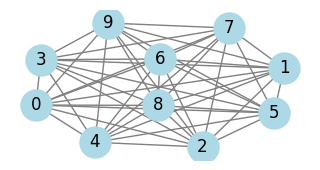

In [5]:
G = nx.Graph()
for weight, (node1, node2) in terms:
    G.add_edge(node1, node2, wight=round(weight, 2))
    
plt.figure(figsize=(3, 1.5))
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=12)


plt.show()

In [6]:
# Step 2: get QAOA objective
# Get objective
p =4
f = get_qaoa_objective(N, terms=terms, parameterization='theta', simulator='gpu')

CudaSupportError: Error at driver init: 
Call to cuInit results in CUDA_ERROR_NO_DEVICE (100):

In [7]:
# Step 3: Optimize QAOA parameters
p = 4
initial_gamma = -1*np.linspace(0, 1, p)
initial_beta = np.linspace(1, 0, p)

res = scipy.optimize.minimize(f, np.hstack([initial_gamma, initial_beta]), method='COBYLA', options={'rhobeg': 0.01})

NameError: name 'f' is not defined

In [ ]:
print(f"Expected QAOA solution quality: {res.fun:.5f}")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(-res.x[:p], label=r"$\gamma$")
plt.plot(res.x[p:], label=r"$\beta$")
plt.title('Optimized QAOA parameters')
plt.legend()

In [ ]:
def f_from_terms_ground_truth(s):
    """ground truth for debugging
    """
    out = 0
    for coeff, (i, j) in terms:
        out += coeff * s[i] * s[j]
    return out

In [ ]:
print(f"True minimum: {brute_force(f_from_terms_ground_truth, N, minimize=True)[0]:.5f}")
